# Python code for this Capstone Project

## Table of Contents
1. Introduction: Business Problem
2. Data Requirements
3. Methodology
4. Analysis
5. Results
6. Discussion
7. Conclusion

## Introduction: Business Problem

In this project I am helping Jay who is a business man and who wants open a South Asian Plaza in Etobicoke. We will be analyzing each neighborhood in Etobicoke in order to help Jay to make his decision.

The information gathered from FourSquare in combination with Data Science methods are a good basis to derive data driven decisions regarding neighbourhoods that best fit the specific needs at hand. We are also going to use K-Means clustering algorithm to achieve the task. Folium visualization library will be used to visualize the clusters superimposed on the map of Etobicoke. These clusters can be analyzed to help Jay to make his decision

#### Import necessary libraries

In [145]:
from bs4 import BeautifulSoup
import requests as rq

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np
import json
import re

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

! pip install folium==0.5.0
import folium
print('folim is installed!')

from sklearn.cluster import KMeans

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

print('Libraries are imported now!')

folim is installed!
Solving environment: done

# All requested packages already installed.

Libraries are imported now!


## Data Requirements

<p> We will use following Wikipedia page to scrape out postal codes of the Toronto area, their respective borough and their neiborhoods. We will be focusing on Etobicoke borough only.</p>
<a href='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'> Wikipedia page </a>

In [300]:
url = rq.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url, 'xml')

table_contents = []
table = soup.find('table')

#table

for row in table.findAll('td'):
    cell = {}
    if row.span.text == 'Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

        
#table_contents
        

Let's create a new dataframe called Zip_df and fix some discrepancies in Borough data

In [301]:
Zip_df=pd.DataFrame(table_contents)
Zip_df['Borough']=Zip_df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
Zip_df.head()
#Zip_df.shape

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


<p> After getting postal codes, borough and neighborhoods from the above wikipedia page, we will be using Google maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood. For simplicity of this project I have gathered all the information in the CSV file. Here is a link to a csv file that has the geographical coordinates of each postal code: <br>
    <a href='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'> GeoSpatial Dataset </a> </p>

In [302]:
# Assign geocode values from csv file to the dataframe
geo_df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')

geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [303]:
# Rename field name to match with Zip_df dataframe
geo_df.rename(columns={'Postal Code':'PostalCode'}, inplace = True)

# Merge Zip_df data to geo_df using PostalCode field
geo_merged = pd.merge(geo_df, Zip_df, on = 'PostalCode')
# geo_merged

# Arrange fields and create TO_df new dataframe
TO_df = geo_merged[['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]
TO_df.head() #Final call for the second notebook

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Create a new dataframe for Etobicoke borough only

In [304]:
EB_df = TO_df[TO_df['Borough'].str.contains('Etobicoke')].reset_index(drop = True)
EB_df.head(15) 
#There are only 12 records so we are good

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M8V,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321
1,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484
2,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
3,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509
4,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724
7,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201
8,M9P,Etobicoke,Westmount,43.696319,-79.532242
9,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724


#### Define Foursquare Credentials & Version

In [305]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'
LIMIT = 100

#### Let's create a function to explore all neighborhoods in Etobicoke

In [306]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = rq.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's run above function on each neighborhood & create a new dataframe called EB_venues

In [307]:
EB_venues = getNearbyVenues(names=EB_df['Neighborhood'],
                                   latitudes=EB_df['Latitude'],
                                   longitudes=EB_df['Longitude']
                                  )
EB_venues.shape

(76, 7)

In [308]:
#EB_venues['Neighborhood'] = EB_venues['Neighborhood'].str.replace('\n',',').astype(str)
EB_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,LCBO,43.602281,-79.499302,Liquor Store
1,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,New Toronto Fish & Chips,43.601849,-79.503281,Restaurant
2,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,Domino's Pizza,43.601583,-79.500905,Pizza Place
3,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,Delicia Bakery & Pastry,43.601403,-79.503012,Bakery
4,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,Lucky Dice Restaurant,43.601392,-79.503056,Café


Let's check how many venues were returned for each neighborhood

In [309]:
EB_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Alderwood, Long Branch",7,7,7,7,7,7
"Clairville, Humberwood, Woodbine Downs, West Humber, Kipling Heights, Rexdale, Elms, Tandridge, Old Rexdale",3,3,3,3,3,3
"Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood",10,10,10,10,10,10
"Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens",4,4,4,4,4,4
"Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West",15,15,15,15,15,15
"New Toronto, Mimico South, Humber Bay Shores",13,13,13,13,13,13
"Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East",2,2,2,2,2,2
"South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens",9,9,9,9,9,9
"The Kingsway, Montgomery Road, Old Mill North",2,2,2,2,2,2


Let's see how many unique categories can be curated from all the returned venues

In [310]:
print('There are {} unique categories.'.format(len(EB_venues['Venue Category'].unique())))


There are 43 unique categories.


## Methodology

<p> Now, we have 12 neighborhoods data of Etobicoke. We also have the most popular venues in each neighborhood obtained using FourSquare API. A total of 76 venues have been obtained in the whole city and 43 unique categories. Here we have only 12 neighborhoods so we will consider and analyze all.</p>
<p> We can perform one hot encoding on the obtained data set and use it to find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset. Here K-Means clustering technique have been used. </p>
<p> The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest Jay some suitable locations based on the category.</p>

## Analysis

Let's visualize the number of venues obtained in all the neighborhoods of Etobicoke

<AxesSubplot:xlabel='Neighborhood'>

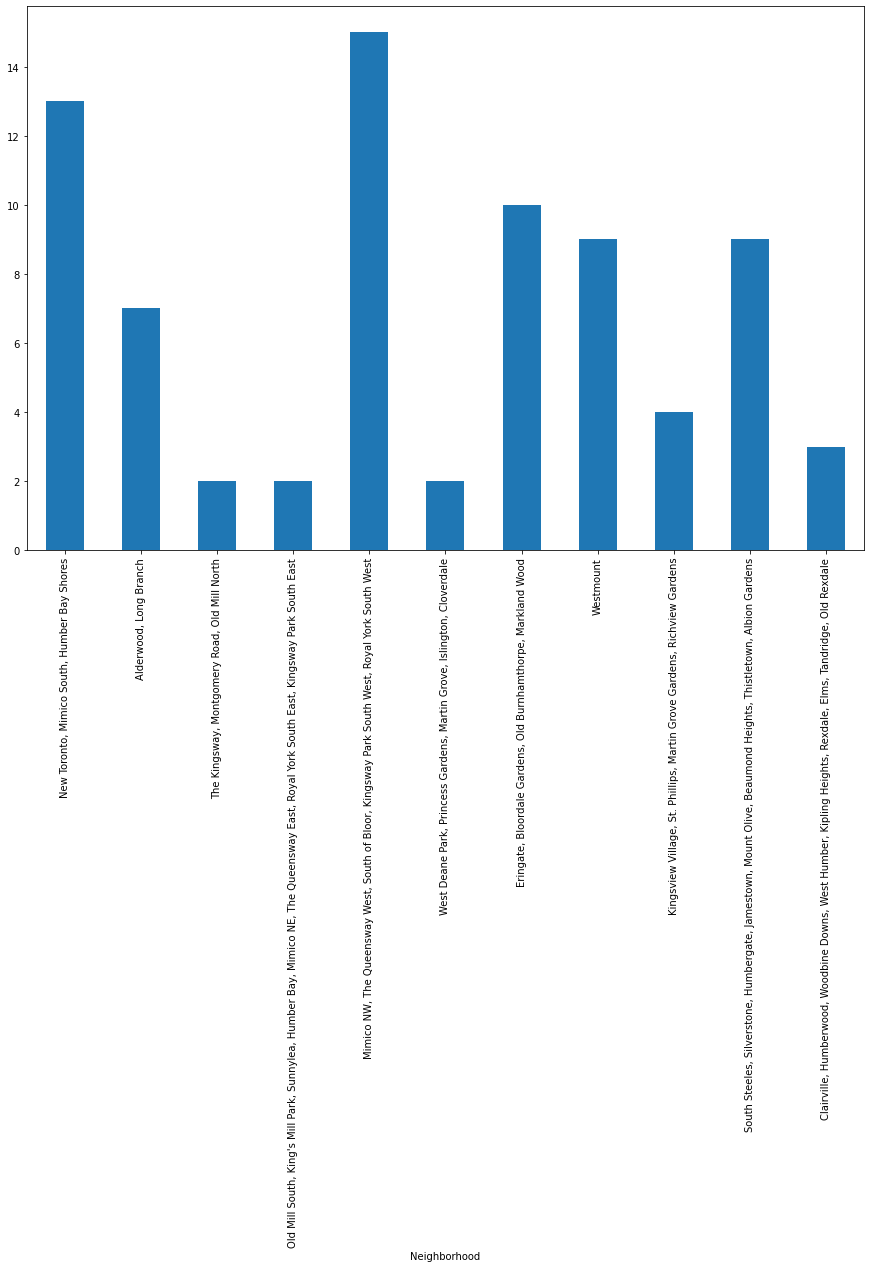

In [311]:
df = EB_venues.groupby(['Neighborhood'], sort = False)['Venue'].count()
df.plot.bar(figsize=(15,10))

#### One hot encoding

In [312]:
EB_onehot = pd.get_dummies(EB_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
EB_onehot['Neighborhood'] = EB_venues['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [EB_onehot.columns[-1]] + list(EB_onehot.columns[:-1])
EB_onehot = EB_onehot[fixed_columns]

EB_onehot.head()


,Neighborhood,American Restaurant,Bakery,Baseball Field,Beer Store,Burger Joint,Burrito Place,Bus Line,Café,Chinese Restaurant,Coffee Shop,Convenience Store,Discount Store,Drugstore,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Fried Chicken Joint,Grocery Store,Gym,Hardware Store,Intersection,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Pub,Rental Car Location,Restaurant,River,Sandwich Place,Seafood Restaurant,Shopping Plaza,Supplement Shop,Tanning Salon,Thrift / Vintage Store,Truck Stop,Wings Joint
0,"New Toronto, Mimico South, Humber Bay Shores",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"New Toronto, Mimico South, Humber Bay Shores",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,"New Toronto, Mimico South, Humber Bay Shores",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"New Toronto, Mimico South, Humber Bay Shores",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"New Toronto, Mimico South, Humber Bay Shores",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now, Let's group rows by neighborhood & by taking the mean of the frequency of occurrence of each category

In [313]:
EB_grouped = EB_onehot.groupby('Neighborhood').mean().reset_index()
EB_grouped

,Neighborhood,American Restaurant,Bakery,Baseball Field,Beer Store,Burger Joint,Burrito Place,Bus Line,Café,Chinese Restaurant,Coffee Shop,Convenience Store,Discount Store,Drugstore,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Fried Chicken Joint,Grocery Store,Gym,Hardware Store,Intersection,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Pub,Rental Car Location,Restaurant,River,Sandwich Place,Seafood Restaurant,Shopping Plaza,Supplement Shop,Tanning Salon,Thrift / Vintage Store,Truck Stop,Wings Joint
0,"Alderwood, Long Branch",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.142857,0.285714,0.000000,0.0,0.142857,0.000000,0.000000,0.0,0.142857,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Clairville, Humberwood, Woodbine Downs, West H...",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000
2,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0.000000,0.000000,0.0,0.100000,0.000000,0.000000,0.00,0.100000,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.00,0.10,0.100000,0.100000,0.100000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Kingsview Village, St. Phillips, Martin Grove ...",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Mimico NW, The Queensway West, South of Bloor,...",0.000000,0.066667,0.0,0.000000,0.066667,0.066667,0.00,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.066667,0.0,0.066667,0.000000,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.066667,0.000000,0.0,0.066667,0.066667,0.066667,0.000000,0.066667
5,"New Toronto, Mimico South, Humber Bay Shores",0.076923,0.076923,0.0,0.000000,0.000000,0.000000,0.00,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.0,0.076923,0.000000,0.000000,0.076923,0.000000,0.000000,0.076923,0.076923,0.000000,0.00,0.00,0.076923,0.076923,0.076923,0.000000,0.0,0.000000,0.000000,0.076923,0.0,0.000000,0.076923,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,"South Steeles, Silverstone, Humbergate, Jamest...",0.000000,0.000000,0.0,0.111111,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.0,0.000000,0.111111,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.111111,0.222222,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
8,"The Kingsway, Montgomery Road, Old Mill North",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000

#### Let's put new dataframe and display Top 10 venues for each neighborhood
But, first, let's write a function to sort the venues in descending order

In [314]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now, let's create a new dataframe for Top 10 Venues

In [315]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = EB_grouped['Neighborhood']

for ind in np.arange(EB_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(EB_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alderwood, Long Branch",Pizza Place,Pub,Sandwich Place,Pharmacy,Gym,Coffee Shop,Convenience Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant
1,"Clairville, Humberwood, Woodbine Downs, West H...",Truck Stop,Drugstore,Rental Car Location,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant
2,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Liquor Store,Café,Park,Pet Store,Pharmacy,Pizza Place,Coffee Shop,Convenience Store,Shopping Plaza,Beer Store
3,"Kingsview Village, St. Phillips, Martin Grove ...",Mobile Phone Shop,Park,Sandwich Place,Bus Line,Wings Joint,Discount Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant
4,"Mimico NW, The Queensway West, South of Bloor,...",Wings Joint,Burger Joint,Grocery Store,Flower Shop,Fast Food Restaurant,Discount Store,Convenience Store,Gym,Burrito Place,Hardware Store
5,"New Toronto, Mimico South, Humber Bay Shores",Liquor Store,Pizza Place,Bakery,Café,Fast Food Restaurant,Flower Shop,Gym,Mexican Restaurant,Pet Store,Pharmacy
6,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Pool,Baseball Field,Wings Joint,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore
7,"South Steeles, Silverstone, Humbergate, Jamest...",Grocery Store,Pizza Place,Fried Chicken Joint,Beer Store,Sandwich Place,Fast Food Restaurant,Pharmacy,Wings Joint,Discount Store,Flower Shop
8,"The Kingsway, Montgomery Road, Old Mill North",Park,River,Wings Joint,Convenience Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore
9,"West Deane Park, Princess Gardens, Martin Grov...",Bakery,Filipino Restaurant,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Fast Food Restaurant,Drugstore


#### Let's create Clusters for Neighborhoods
Here K-Means clustering technique is used. 

In [316]:
# set number of clusters
kclusters = 7

EB_grouped_clustering = EB_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(EB_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 5, 6, 0, 6, 6, 3, 1, 4, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [317]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

EB_merged = EB_venues[EB_venues.columns[0:3]].drop_duplicates()
EB_merged.reset_index(drop = True, inplace = True)

# merge EB_merged with EB_df to add latitude/longitude for each neighborhood
EB_merged = EB_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

EB_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,6,Liquor Store,Pizza Place,Bakery,Café,Fast Food Restaurant,Flower Shop,Gym,Mexican Restaurant,Pet Store,Pharmacy
1,"Alderwood, Long Branch",43.602414,-79.543484,1,Pizza Place,Pub,Sandwich Place,Pharmacy,Gym,Coffee Shop,Convenience Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant
2,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,4,Park,River,Wings Joint,Convenience Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore
3,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,3,Pool,Baseball Field,Wings Joint,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore
4,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,6,Wings Joint,Burger Joint,Grocery Store,Flower Shop,Fast Food Restaurant,Discount Store,Convenience Store,Gym,Burrito Place,Hardware Store


In [318]:
EB_merged

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,6,Liquor Store,Pizza Place,Bakery,Café,Fast Food Restaurant,Flower Shop,Gym,Mexican Restaurant,Pet Store,Pharmacy
1,"Alderwood, Long Branch",43.602414,-79.543484,1,Pizza Place,Pub,Sandwich Place,Pharmacy,Gym,Coffee Shop,Convenience Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant
2,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,4,Park,River,Wings Joint,Convenience Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore
3,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,3,Pool,Baseball Field,Wings Joint,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore
4,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,6,Wings Joint,Burger Joint,Grocery Store,Flower Shop,Fast Food Restaurant,Discount Store,Convenience Store,Gym,Burrito Place,Hardware Store
5,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,2,Bakery,Filipino Restaurant,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Fast Food Restaurant,Drugstore
6,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201,6,Liquor Store,Café,Park,Pet Store,Pharmacy,Pizza Place,Coffee Shop,Convenience Store,Shopping Plaza,Beer Store
7,Westmount,43.696319,-79.532242,1,Pizza Place,Intersection,Middle Eastern Restaurant,Sandwich Place,Chinese Restaurant,Coffee Shop,Discount Store,Playground,Wings Joint,Fried Chicken Joint
8,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,0,Mobile Phone Shop,Park,Sandwich Place,Bus Line,Wings Joint,Discount Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant
9,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,1,Grocery Store,Pizza Place,Fried Chicken Joint,Beer Store,Sandwich Place,Fast Food Restaurant,Pharmacy,Wings Joint,Discount Store,Flower Shop


#### Data wrangling

In [350]:
# In order to convert float to integer, we need to make sure that there is no NaN present
EB_merged['Cluster Labels'] = EB_merged['Cluster Labels'].replace(np.nan, 0)

#EB_merged['Cluster Labels'] = EB_merged['Cluster Labels'].apply(np.int64)

# +1 added to each cluster lables so 0 will become 1. 1 will become 2
EB_merged['Cluster Labels'] = EB_merged['Cluster Labels'] + 1

#EB_merged = EB_merged.drop(['PostalCode'], axis=1)

#EB_merged.head()
EB_merged

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,7,Liquor Store,Pizza Place,Bakery,Café,Fast Food Restaurant,Flower Shop,Gym,Mexican Restaurant,Pet Store,Pharmacy
1,"Alderwood, Long Branch",43.602414,-79.543484,2,Pizza Place,Pub,Sandwich Place,Pharmacy,Gym,Coffee Shop,Convenience Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant
2,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,5,Park,River,Wings Joint,Convenience Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore
3,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,4,Pool,Baseball Field,Wings Joint,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore
4,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,7,Wings Joint,Burger Joint,Grocery Store,Flower Shop,Fast Food Restaurant,Discount Store,Convenience Store,Gym,Burrito Place,Hardware Store
5,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,3,Bakery,Filipino Restaurant,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Fast Food Restaurant,Drugstore
6,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201,7,Liquor Store,Café,Park,Pet Store,Pharmacy,Pizza Place,Coffee Shop,Convenience Store,Shopping Plaza,Beer Store
7,Westmount,43.696319,-79.532242,2,Pizza Place,Intersection,Middle Eastern Restaurant,Sandwich Place,Chinese Restaurant,Coffee Shop,Discount Store,Playground,Wings Joint,Fried Chicken Joint
8,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,1,Mobile Phone Shop,Park,Sandwich Place,Bus Line,Wings Joint,Discount Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant
9,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,2,Grocery Store,Pizza Place,Fried Chicken Joint,Beer Store,Sandwich Place,Fast Food Restaurant,Pharmacy,Wings Joint,Discount Store,Flower Shop


#### Let's visualize the resulting clusters 
But, first, let's define geographical coordinates of Etobicoke

In [352]:
address = 'Etobicoke, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Etobicoke are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Etobicoke are 43.6435559, -79.5656326.


Now, let's visualize clusters in map

In [353]:
# create map
map_clusters = folium.Map(width=1000, height=450, location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(EB_merged['Neighborhood Latitude'], EB_merged['Neighborhood Longitude'], EB_merged['Neighborhood'], EB_merged['Cluster Labels']):
    label = folium.Popup('Cluster '+ str(cluster) +': '+ str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=11,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
#folium.map.LayerControl('topleft', collapsed = False).add_to(map_clusters)
map_clusters

## Results

Let's analyze each clusters 

#### Cluster: 1

In [354]:
cluster1 = EB_merged.loc[EB_merged['Cluster Labels'] == 1, EB_merged.columns[[0] + list(range(4, EB_merged.shape[1]))]]
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Kingsview Village, St. Phillips, Martin Grove ...",Mobile Phone Shop,Park,Sandwich Place,Bus Line,Wings Joint,Discount Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant


In [355]:

venues1 = (cluster1['1st Most Common Venue'].append
    (cluster1['2nd Most Common Venue']).append
    (cluster1['3rd Most Common Venue']).append
    (cluster1['4th Most Common Venue']).append
    (cluster1['5th Most Common Venue']).append
    (cluster1['6th Most Common Venue']).append
    (cluster1['7th Most Common Venue']).append
    (cluster1['8th Most Common Venue']).append
    (cluster1['9th Most Common Venue']).append
    (cluster1['10th Most Common Venue'])
          )
venues1.value_counts()

Discount Store         1
Park                   1
Mobile Phone Shop      1
Wings Joint            1
Sandwich Place         1
Fried Chicken Joint    1
Grocery Store          1
Flower Shop            1
Bus Line               1
Filipino Restaurant    1
dtype: int64

#### Cluster: 2

In [356]:
cluster2 = EB_merged.loc[EB_merged['Cluster Labels'] == 2, EB_merged.columns[[0] + list(range(4, EB_merged.shape[1]))]]
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Alderwood, Long Branch",Pizza Place,Pub,Sandwich Place,Pharmacy,Gym,Coffee Shop,Convenience Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant
7,Westmount,Pizza Place,Intersection,Middle Eastern Restaurant,Sandwich Place,Chinese Restaurant,Coffee Shop,Discount Store,Playground,Wings Joint,Fried Chicken Joint
9,"South Steeles, Silverstone, Humbergate, Jamest...",Grocery Store,Pizza Place,Fried Chicken Joint,Beer Store,Sandwich Place,Fast Food Restaurant,Pharmacy,Wings Joint,Discount Store,Flower Shop


In [357]:

venues2 = (cluster2['1st Most Common Venue'].append
    (cluster2['2nd Most Common Venue']).append
    (cluster2['3rd Most Common Venue']).append
    (cluster2['4th Most Common Venue']).append
    (cluster2['5th Most Common Venue']).append
    (cluster2['6th Most Common Venue']).append
    (cluster2['7th Most Common Venue']).append
    (cluster2['8th Most Common Venue']).append
    (cluster2['9th Most Common Venue']).append
    (cluster2['10th Most Common Venue'])
          )
venues2.value_counts()

Pizza Place                  3
Fried Chicken Joint          3
Sandwich Place               3
Flower Shop                  2
Discount Store               2
Coffee Shop                  2
Pharmacy                     2
Wings Joint                  2
Fast Food Restaurant         1
Gym                          1
Intersection                 1
Middle Eastern Restaurant    1
Playground                   1
Pub                          1
Grocery Store                1
Beer Store                   1
Filipino Restaurant          1
Convenience Store            1
Chinese Restaurant           1
dtype: int64

#### cluster 3

In [358]:
cluster3 = EB_merged.loc[EB_merged['Cluster Labels'] == 3, EB_merged.columns[[0] + list(range(4, EB_merged.shape[1]))]]
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"West Deane Park, Princess Gardens, Martin Grov...",Bakery,Filipino Restaurant,Wings Joint,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Fast Food Restaurant,Drugstore


In [359]:

venues3 = (cluster3['1st Most Common Venue'].append
    (cluster3['2nd Most Common Venue']).append
    (cluster3['3rd Most Common Venue']).append
    (cluster3['4th Most Common Venue']).append
    (cluster3['5th Most Common Venue']).append
    (cluster3['6th Most Common Venue']).append
    (cluster3['7th Most Common Venue']).append
    (cluster3['8th Most Common Venue']).append
    (cluster3['9th Most Common Venue']).append
    (cluster3['10th Most Common Venue'])
          )
venues3.value_counts()

Fast Food Restaurant    1
Fried Chicken Joint     1
Wings Joint             1
Flower Shop             1
Filipino Restaurant     1
Grocery Store           1
Convenience Store       1
Gym                     1
Drugstore               1
Bakery                  1
dtype: int64

#### cluster 4

In [360]:
cluster4 = EB_merged.loc[EB_merged['Cluster Labels'] == 4, EB_merged.columns[[0] + list(range(4, EB_merged.shape[1]))]]
cluster4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Pool,Baseball Field,Wings Joint,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore


In [361]:

venues4 = (cluster4['1st Most Common Venue'].append
    (cluster4['2nd Most Common Venue']).append
    (cluster4['3rd Most Common Venue']).append
    (cluster4['4th Most Common Venue']).append
    (cluster4['5th Most Common Venue']).append
    (cluster4['6th Most Common Venue']).append
    (cluster4['7th Most Common Venue']).append
    (cluster4['8th Most Common Venue']).append
    (cluster4['9th Most Common Venue']).append
    (cluster4['10th Most Common Venue'])
          )
venues4.value_counts()

Fast Food Restaurant    1
Fried Chicken Joint     1
Wings Joint             1
Pool                    1
Grocery Store           1
Flower Shop             1
Gym                     1
Drugstore               1
Filipino Restaurant     1
Baseball Field          1
dtype: int64

#### cluster 5

In [362]:
cluster5 = EB_merged.loc[EB_merged['Cluster Labels'] == 5, EB_merged.columns[[0] + list(range(4, EB_merged.shape[1]))]]
cluster5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"The Kingsway, Montgomery Road, Old Mill North",Park,River,Wings Joint,Convenience Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore


In [363]:

venues5 = (cluster5['1st Most Common Venue'].append
    (cluster5['2nd Most Common Venue']).append
    (cluster5['3rd Most Common Venue']).append
    (cluster5['4th Most Common Venue']).append
    (cluster5['5th Most Common Venue']).append
    (cluster5['6th Most Common Venue']).append
    (cluster5['7th Most Common Venue']).append
    (cluster5['8th Most Common Venue']).append
    (cluster5['9th Most Common Venue']).append
    (cluster5['10th Most Common Venue'])
          )
venues5.value_counts()

River                   1
Park                    1
Fried Chicken Joint     1
Wings Joint             1
Flower Shop             1
Fast Food Restaurant    1
Grocery Store           1
Convenience Store       1
Drugstore               1
Filipino Restaurant     1
dtype: int64

#### cluster 6

In [364]:
cluster6 = EB_merged.loc[EB_merged['Cluster Labels'] == 6, EB_merged.columns[[0] + list(range(4, EB_merged.shape[1]))]]
cluster6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"Clairville, Humberwood, Woodbine Downs, West H...",Truck Stop,Drugstore,Rental Car Location,Convenience Store,Gym,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant,Fast Food Restaurant


In [365]:

venues6 = (cluster6['1st Most Common Venue'].append
    (cluster6['2nd Most Common Venue']).append
    (cluster6['3rd Most Common Venue']).append
    (cluster6['4th Most Common Venue']).append
    (cluster6['5th Most Common Venue']).append
    (cluster6['6th Most Common Venue']).append
    (cluster6['7th Most Common Venue']).append
    (cluster6['8th Most Common Venue']).append
    (cluster6['9th Most Common Venue']).append
    (cluster6['10th Most Common Venue'])
          )
venues6.value_counts()

Fast Food Restaurant    1
Fried Chicken Joint     1
Rental Car Location     1
Flower Shop             1
Grocery Store           1
Convenience Store       1
Gym                     1
Drugstore               1
Filipino Restaurant     1
Truck Stop              1
dtype: int64

#### cluster 7

In [366]:
cluster7 = EB_merged.loc[EB_merged['Cluster Labels'] == 7, EB_merged.columns[[0] + list(range(4, EB_merged.shape[1]))]]
cluster7

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New Toronto, Mimico South, Humber Bay Shores",Liquor Store,Pizza Place,Bakery,Café,Fast Food Restaurant,Flower Shop,Gym,Mexican Restaurant,Pet Store,Pharmacy
4,"Mimico NW, The Queensway West, South of Bloor,...",Wings Joint,Burger Joint,Grocery Store,Flower Shop,Fast Food Restaurant,Discount Store,Convenience Store,Gym,Burrito Place,Hardware Store
6,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Liquor Store,Café,Park,Pet Store,Pharmacy,Pizza Place,Coffee Shop,Convenience Store,Shopping Plaza,Beer Store


In [367]:

venues7 = (cluster7['1st Most Common Venue'].append
    (cluster7['2nd Most Common Venue']).append
    (cluster7['3rd Most Common Venue']).append
    (cluster7['4th Most Common Venue']).append
    (cluster7['5th Most Common Venue']).append
    (cluster7['6th Most Common Venue']).append
    (cluster7['7th Most Common Venue']).append
    (cluster7['8th Most Common Venue']).append
    (cluster7['9th Most Common Venue']).append
    (cluster7['10th Most Common Venue'])
          )
venues7.value_counts()

Pharmacy                2
Liquor Store            2
Convenience Store       2
Gym                     2
Fast Food Restaurant    2
Pizza Place             2
Pet Store               2
Café                    2
Flower Shop             2
Burger Joint            1
Bakery                  1
Coffee Shop             1
Grocery Store           1
Discount Store          1
Mexican Restaurant      1
Beer Store              1
Hardware Store          1
Shopping Plaza          1
Burrito Place           1
Wings Joint             1
Park                    1
dtype: int64

#### cluster 8 
There is no cluster 8 but let's mimic it from cluster 1 so the next visualization look okay

In [372]:
cluster8 = EB_merged.loc[EB_merged['Cluster Labels'] == 1, EB_merged.columns[[0] + list(range(4, EB_merged.shape[1]))]]
cluster8

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Kingsview Village, St. Phillips, Martin Grove ...",Mobile Phone Shop,Park,Sandwich Place,Bus Line,Wings Joint,Discount Store,Grocery Store,Fried Chicken Joint,Flower Shop,Filipino Restaurant


In [373]:

venues8 = (cluster8['1st Most Common Venue'].append
    (cluster8['2nd Most Common Venue']).append
    (cluster8['3rd Most Common Venue']).append
    (cluster8['4th Most Common Venue']).append
    (cluster8['5th Most Common Venue']).append
    (cluster8['6th Most Common Venue']).append
    (cluster8['7th Most Common Venue']).append
    (cluster8['8th Most Common Venue']).append
    (cluster8['9th Most Common Venue']).append
    (cluster8['10th Most Common Venue'])
          )
venues8.value_counts()

Discount Store         1
Park                   1
Mobile Phone Shop      1
Wings Joint            1
Sandwich Place         1
Fried Chicken Joint    1
Grocery Store          1
Flower Shop            1
Bus Line               1
Filipino Restaurant    1
dtype: int64

## Discussion

Let's visualize the top 5 most common venue categories in each cluster

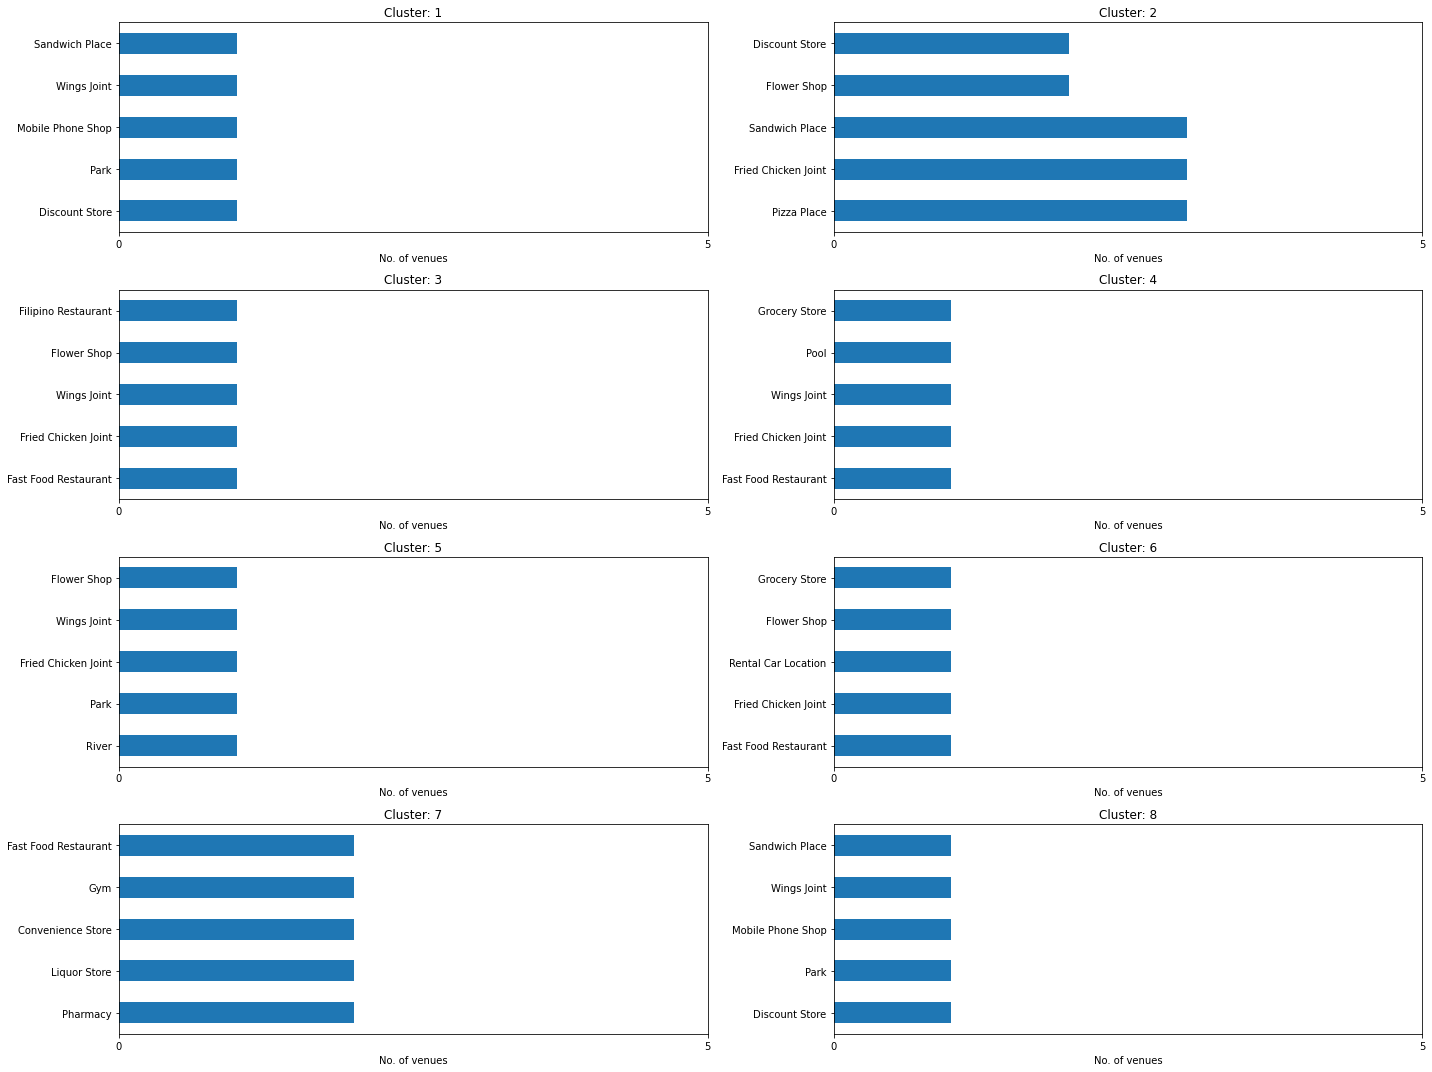

In [374]:
cluster_list = [venues1, venues2, venues3, venues4, venues5, venues6, venues7, venues8]

fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        cluster_list[count].value_counts().head().plot.barh(ax = axes[r,c], width = 0.5, figsize = (20,15))
        axes[r,c].set_title('Cluster: {}'.format(count+1))
        plt.sca(axes[r,c])
        plt.xticks(np.arange(0, 10, 5))
        plt.xlabel('No. of venues')
        count = count + 1
        
fig.tight_layout()

#### Map of Etobicoke with the clusters superimposed on top

In [375]:
# create map
map_clusters = folium.Map(width=1000, height=450, location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(EB_merged['Neighborhood Latitude'], EB_merged['Neighborhood Longitude'], EB_merged['Neighborhood'], EB_merged['Cluster Labels']):
    label = folium.Popup('Cluster '+ str(cluster) +': '+ str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=11,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
#folium.map.LayerControl('topleft', collapsed = False).add_to(map_clusters)
map_clusters

<p> Let's discuss two clusters and their associated neighborhoods where Jay can consider to open his South Asian Plaza  </p>
<p> <b> Cluster 2: </b> <br>
    It's very clear that their are many venues belong to this cluster such as few pizza places, some asian restaurants, fast food restaurants, playground, gym, etc. so it clearly gives an advantage to open any business in these neighborhoods. Jay can open his plaza in either <b> Westmount </b> neighborhood or near <b>Humbergate</b>. Let's discuss few advantages of these two neighborhoods.<br>
<b> Westmount:</b> As it shows in the map, it's very near to highway 401 which can attract daily commuters to this plaza. Moreover, this neighborhood is in residence area so it's possible that this plaza would attract many inhabitants and not just South Asian community. 
<b> Humbergate:</b> As it is depicted in the above map that this area is very near to Humber College and also to very popular Hindu temple (BAPS table) which can attract many students and devotees.
</p>
<p> <b> Cluster 1: </b><br> Kingsview village in this cluster is very similar to the Westmount area of cluster 2. In addition to that, it has Bus line too so it may attract some people who has no vehicles such as students. </p>

## Conclusion

<p> In this project, the purpose was to analyze all the neighborhoods located in Etobicoke city and cluster them using k-Means clustering techniques. We had to provide suggestion to Jay so he could open his plaza in suggested neighborhoods. We used FourSqure API to get necessary information of venues located near to each neighborhoods and their respective geospatial data. As we saw in previous visualization in discussion section there are not many popular neighborhoods in Etobicoke except some</p>
<p> So, we took few neighborhoods into consideration and we provided suggestion that Jay can open his plaza either in Westmount or near to Humbergate. Kingsview village is very similar to Westmount neighborhood so we can remove Kingsview village from the consideration. We strongly recommend that Jay opens his plaza near to Humbergate area because it would boost his business. This place is very near to Humber college and some popular religious places nearby </p>

## THANK YOU